# EPIC-2037_Fitting+MCMC

Using EPIC-2037 (K2-24) dataset, we demonstrate how to

- perform a max-likelihood fit
- do an MCMC exploration of the posterior space



In [11]:
# Preliminary imports
%pylab inline
import radvel
import pandas as pd
import os
from scipy import optimize
import corner
rc('savefig',dpi=120)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [12]:
# Load up EPIC-2037 data
path = os.path.join(radvel.DATADIR,'epic203771098.hdf')
planet = pd.read_hdf(path,'planet')
rv = pd.read_hdf(path,'rv')
def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = planet.ix['P','b']
    params['tc1'] = planet.ix['t0','b']
    params['secosw1'] = 0.01
    params['sesinw1'] = 0.01
    params['logk1'] = 1
    params['per2'] = planet.ix['P','c']
    params['tc2'] = planet.ix['t0','c']
    params['secosw2'] = 0.01
    params['sesinw2'] = 0.01
    params['logk2'] = 1
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = -0.02
    mod.params['curv'] = 0.0
    return mod

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

In [13]:
# Convenience function to plot model and residuals
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    xlabel('Time')
    ylabel('RV')
    draw()

Fit EPIC-2307 light curve
=========================
1. circular orbits
2. fixed period, time of transit

In [14]:
mod = initialize_model()

KeyError: 'gamma'

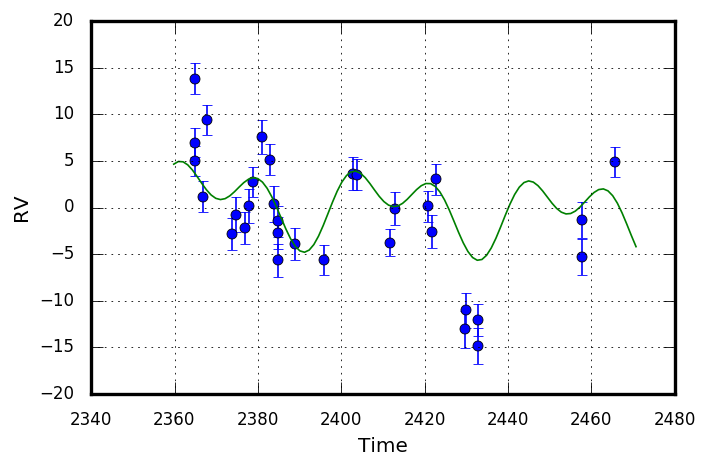

In [15]:
# Set initial values of the parameters
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 0.0
like.params['logjit'] = np.log(1)

# Determin which parameters vary and which do not
like.vary['secosw1'] = False
like.vary['sesinw1'] = False
like.vary['secosw2'] = False
like.vary['sesinw2'] = False
like.vary['per1'] = False
like.vary['per2'] = False
like.vary['tc1'] = False
like.vary['tc2'] = False
like.vary['curv'] = False

figure()
plot_results(like) # Plot initial model
print like

In [ ]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian( 'logjit', log(3), 0.5)]
post.priors += [radvel.prior.Gaussian( 'logk2', log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'logk1', log(5), 10)]
post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]

res  = optimize.minimize(
    post.neglogprob_array, # objective function is negative log likelihood
    post.get_vary_params(), # initial variable parameters
    method='Powell', # Nelder-Mead also works
    )

#print res
#print like_syn
fig = figsize(12,4)
plot_results(like) # plot best fit model
print post

In [ ]:
df = radvel.mcmc(post,threads=1,nburn=1000,nwalkers=20,nrun=1000)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

In [ ]:
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df.sort('lnprobability').iloc[1000:][labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

Fit EPIC-2307 light curve
=========================
1. eccentric orbits
2. fixed period, time of transit

In [ ]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, array(rv.t), array(rv.vel), array(rv.errvel))

# Eccentric orbits
like.params['gamma'] = 0.1
like.params['logjit'] = np.log(2)

# Some syntactic sugar to update multiple fields at once
like.vary.update(per1=False,per2=False,tc1=False,tc2=False)
like.params.update(secosw1=0.1,sesinw1=0.1,secosw2=0.1,sesinw2=0.1)
plot_results(like) # plot best fit model
print like

In [ ]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'logjit', log(2),0.1)]

#plot_results(like) # Plot initial model
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Nelder-Mead',)

plot_results(like) # plot best fit model
print post

In [ ]:
df = radvel.mcmc(post,threads=1,nburn=1000,nwalkers=20,nrun=1000)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],labels=labels,levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

In [ ]:
df['k1'] = exp(df['logk1'])
df['k2'] = exp(df['logk2'])
df['jit'] = exp(df['logjit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2

df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])


labels = 'k1 k2 jit e1 e2'.split()
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    quantiles=[.14,.5,.84]
    )

In [ ]:
df[labels].describe()